# NCI WeatherBench-1a: Create climatology and persistence forecasts

In this note book we will create the most basic baselines: persistence and climatology forecasts. We will do this for 500hPa geopotential, 850hPa temperature, precipitation and 2 meter temperature.

Note: The entire dataset would Require an 191GB ARE instance to run

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from score import *
import logging 
import xarray as xr
from datetime import datetime
import dask
from dask.distributed import Client
import gc
from datetime import datetime

In [2]:
client = Client(n_workers=12, threads_per_worker=1)  
client

/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.wa

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33565,Workers: 12
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 95.00 GiB
Comm: tcp://127.0.0.1:40275,Total threads: 1
Dashboard: /proxy/38735/status,Memory: 7.92 GiB
Nanny: tcp://127.0.0.1:38741,


In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

## Load data - '5.625deg'

First, we need to specify the directories and load the data.

In [4]:
res = '5.625'
# Location of WeatherBench dataset
DATADIR = f'/g/data/wb00/NCI-Weatherbench/{res}deg' 
# Location to store baseline forecasts
PREDDIR = f"/scratch/vp91/{os.environ['USER']}/NCI-Weatherbench/pred_dir" 
print('DATADIR:', DATADIR)
print('PREDDIR:', PREDDIR)
! mkdir -p {PREDDIR} 

DATADIR: /g/data/wb00/NCI-Weatherbench/5.625deg
PREDDIR: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir


## Data directory structure

In [5]:
!ls '/g/data/wb00/NCI-Weatherbench/'

1.40625deg  2.8125deg  5.625deg  license.txt


In [6]:
!ls $DATADIR/

10m_u_component_of_wind  potential_vorticity	       total_cloud_cover
10m_v_component_of_wind  relative_humidity	       total_precipitation
2m_temperature		 specific_humidity	       u_component_of_wind
constants.nc		 temperature		       v_component_of_wind
geopotential		 toa_incident_solar_radiation  vorticity


In [7]:
xr.open_mfdataset(f'{DATADIR}/2m_temperature/*.nc', combine='by_coords', parallel=True)

<xarray.Dataset>
Dimensions:  (time: 561024, lat: 32, lon: 64)
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 ... 2022-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [8]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
years = list(range(1999, 2022+1))
print (years)

z500_files = [ file for year in years for file in glob.glob (fr'{DATADIR}/geopotential/*{year}*')  ] 
t850_files = [ file for year in years for file in glob.glob (fr'{DATADIR}/temperature/*{year}*')    ] 
tp_files   = [ file for year in years for file in glob.glob (fr'{DATADIR}/total_precipitation/*{year}*')   ]  
t2m_files  = [ file for year in years for file in glob.glob (fr'{DATADIR}/2m_temperature/*{year}*')   ]  

[2024-03-26 14:56:09]
[1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [9]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

# Load the dataset according to the selected year above
z500 = xr.open_mfdataset(z500_files, combine='by_coords', parallel=True, chunks={'time': 10}).z.sel(level=500).load()  
t850 = xr.open_mfdataset(t850_files, combine='by_coords', parallel=True, chunks={'time': 10}).t.sel(level=850).drop('level').load()  

# convert to 6 hourly accumulation
tp  = xr.open_mfdataset(tp_files,  combine='by_coords', parallel=True, chunks={'time': 10}).tp.rolling(time=6).sum().load()  
t2m = xr.open_mfdataset(t2m_files, combine='by_coords', parallel=True, chunks={'time': 10}).t2m.load()  
tp.name = 'tp'
data = xr.merge([z500, t850, tp, t2m]).compute()

[2024-03-26 14:56:09]
CPU times: user 9min 2s, sys: 44.8 s, total: 9min 47s
Wall time: 12min 5s


In [10]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

# Load the validation subset of the data: 2021 and 2022
valid_years = list(range(2021, 2022+1))
print ('valid_years:', valid_years)

z500_valid_files = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/geopotential/*{year}*') ] 
t850_valid_files = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/temperature/*{year}*')  ] 
tp_valid_files   = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/total_precipitation/*{year}*') ] 
t2m_valid_files  = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/2m_temperature/*{year}*') ] 

z500_valid = load_test_data(z500_valid_files, 'z',  slice('2021', '2022' ))  
t850_valid = load_test_data(t850_valid_files, 't',  slice('2021', '2022' ))  
tp_valid   = load_test_data(tp_valid_files,   'tp', slice('2021', '2022' )).rolling(time=6).sum()
tp_valid.name = 'tp'
t2m_valid  = load_test_data(t2m_valid_files, 't2m', slice('2021', '2022' )) 
valid_data = xr.merge([z500_valid, t850_valid, tp_valid, t2m_valid]).compute()

[2024-03-26 15:08:14]
valid_years: [2021, 2022]
load_test_data, var: z
load_test_data, var: t
load_test_data, var: tp
load_test_data, var: t2m
CPU times: user 28.1 s, sys: 2.13 s, total: 30.3 s
Wall time: 32.2 s


## Persistence forecast

Persistence simply means: Tomorrow's weather is today's weather.

In [11]:
def create_persistence_forecast(ds, lead_time_h):
    assert lead_time_h > 0, 'Lead time must be greater than 0'
    ds_fc = ds.isel(time=slice(0, -lead_time_h))
    return ds_fc

In [12]:
lead_times = xr.DataArray(
    np.arange(6, 126, 6), dims=['lead_time'], coords={'lead_time': np.arange(6, 126, 6)}, name='lead_time')

In [13]:
%%time
persistence = []
for l in lead_times:
    persistence.append(create_persistence_forecast(valid_data, int(l)))
persistence = xr.concat(persistence, dim=lead_times)

CPU times: user 8.71 s, sys: 6.94 s, total: 15.6 s
Wall time: 12.7 s


In [14]:
persistence

<xarray.Dataset>
Dimensions:    (time: 17514, lat: 32, lon: 64, lead_time: 20)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 ... 2022-12-31T17:00:00
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Data variables:
    z          (lead_time, time, lat, lon) float32 4.864e+04 4.864e+04 ... nan
    t          (lead_time, time, lat, lon) float32 254.0 254.0 253.9 ... nan nan
    tp         (lead_time, time, lat, lon) float32 nan nan nan ... nan nan nan
    t2m        (lead_time, time, lat, lon) float32 242.9 242.4 241.9 ... nan nan

The forecast files have dimensions `[init_time, lead_time, lat, lon]`. Let's now save these files so we can evaluate them later.

In [15]:
%%time
save_prefix = 'NCI_tutorial' 
print ('save_prefix:', save_prefix)
print ('Saving results:', f'{PREDDIR}/{save_prefix}_persistence_{res}.nc')
persistence.to_netcdf(    f'{PREDDIR}/{save_prefix}_persistence_{res}.nc')

save_prefix: NCI_tutorial
Saving results: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/NCI_tutorial_persistence_5.625.nc
CPU times: user 1.92 s, sys: 8.22 s, total: 10.1 s
Wall time: 9.55 s


## Climatology forecast

First let's create a single climatology from the entire training dataset (meaning everything before 2021).

In [16]:
def create_climatology_forecast(ds_train):
    return ds_train.mean('time')

In [17]:
train_data = data.sel(time=slice( '1999', '2020'))

In [18]:
climatology = create_climatology_forecast(train_data)

In [19]:
climatology

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64)
Coordinates:
    level    int32 500
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (lat, lon) float32 4.888e+04 4.889e+04 ... 5.134e+04 5.134e+04
    t        (lat, lon) float32 241.8 242.0 241.9 241.8 ... 259.6 259.7 259.7
    tp       (lat, lon) float32 2.961e-05 2.867e-05 ... 0.0001751 0.0001799
    t2m      (lat, lon) float32 228.8 228.5 228.0 227.9 ... 259.8 260.0 260.1

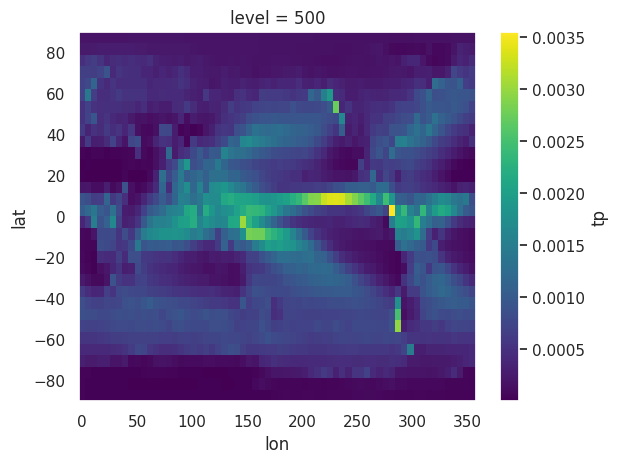

In [20]:
climatology.tp.plot();

In [21]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
print('Saving result:', f'{PREDDIR}/{save_prefix}_climatology_{res}.nc')
climatology.to_netcdf(  f'{PREDDIR}/{save_prefix}_climatology_{res}.nc')


[2024-03-26 15:09:15]
Saving result: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/NCI_tutorial_climatology_5.625.nc


## Climatology  forecast by week

We can create amuch better climatology by taking the seasonal cycle into account. Here we will do this by creating a separate climatology for every week.

In [22]:
def create_weekly_climatology_forecast(ds_train, valid_time):
    ds_train['week'] = ds_train['time.week']
    weekly_averages = ds_train.groupby('week').mean('time')
    valid_time['week'] = valid_time['time.week']
    fc_list = []
    for t in valid_time:
        fc_list.append(weekly_averages.sel(week=t.week))
    return xr.concat(fc_list, dim=valid_time)

In [23]:
%%time 
print( f'[{datetime.now().replace(microsecond=0)}]' )
weekly_climatology = create_weekly_climatology_forecast(train_data, valid_data.time)

[2024-03-26 15:09:15]
CPU times: user 42.8 s, sys: 1.77 s, total: 44.6 s
Wall time: 42.9 s


In [24]:
weekly_climatology

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
    level    int32 500
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
    week     (time) int64 53 53 53 53 53 53 53 53 53 ... 52 52 52 52 52 52 52 52
  * time     (time) datetime64[ns] 2021-01-01 ... 2022-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 5.005e+04 5.007e+04 ... 5e+04 4.999e+04
    t        (time, lat, lon) float32 255.3 255.4 255.4 ... 253.0 253.0 253.0
    tp       (time, lat, lon) float32 5.689e-06 6.561e-06 ... 0.0001709
    t2m      (time, lat, lon) float32 247.1 246.8 246.5 ... 250.8 251.1 251.2

In [25]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
print ('Saving result:',     f'{PREDDIR}/{save_prefix}_weekly_climatology_{res}.nc')
weekly_climatology.to_netcdf(f'{PREDDIR}/{save_prefix}_weekly_climatology_{res}.nc')

[2024-03-26 15:09:58]
Saving result: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/NCI_tutorial_weekly_climatology_5.625.nc


#### Reset everything 

In [26]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
client.shutdown()

[2024-03-26 15:09:59]


#### Note: 
Notebook 1b contains the same functions for higher resolution data

# The End